In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy
import pickle

In [2]:
warnings.simplefilter("ignore")

howmanydifs = 3
allvalues_perset = pickle.load(open("./data/allvalues_perset.p", "rb"))
methods = pickle.load(open("./data/methods.p", "rb"))
fullsetnames = pickle.load(open("./data/fullsetnames.p", "rb"))
functionals = pickle.load(open("./data/functionals.p", "rb"))
basis_sets = pickle.load(open("./data/basis_sets.p", "rb"))
supersetnames = pickle.load(open("./data/supersetnames.p", "rb"))

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmad = None
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestinsidemethod_wtmad:
                models_results[setname].bestinsidemethod_wtmad = wtmad
                models_results[setname].bestinsidemethod_name_wtmad = str(methodid)
                models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmad = None            
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestourmethod_wtmad:
                models_results[setname].bestourmethod_wtmad = wtmad
                models_results[setname].bestourmethod_name_wtmad = method
                models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

bestmnethodscount = {}
setofbestourmethodswtamd = {}

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    if models_results[setname].bestourmethod_name_rmse in bestmnethodscount:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] += 1
    else:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] = 1

    if models_results[setname].bestourmethod_name_wtmad != "":
        if models_results[setname].bestourmethod_name_wtmad in setofbestourmethodswtamd:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] += 1
        else:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] = 1
          
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           0  ,    8.201  ,           0  ,   17.010  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,   10.520
                    BARRIER_HEIGHTS_BH76  ,           0  ,   10.387  ,              ,      inf  ,   PBE0-TZVP  ,    5.505  ,              ,      inf
                 BARRIER_HEIGHTS_BHDIV10  ,           0  ,    9.191  ,              ,      inf  ,   PBE0-TZVP  ,    5.278  ,              ,      inf
                  BARRIER_HEIGHTS_BHPERI  ,           0  ,    4.407  ,              ,      inf  ,   PBE0-TZVP  ,    3.762  ,              ,      inf
                 BARRIER_HEIGHTS_BHROT27  ,           1  ,    0.611  ,              ,      inf  ,    PBE-TZVP  ,    0.718  ,              ,      inf
                   BARRIER_HE

In [5]:
print("RMSE")
for method in bestmnethodscount:
    print("Best our method ", method, " count: ", bestmnethodscount[method])

print()
print("WTMAD2")
for method in setofbestourmethodswtamd:
    print("Best our method ", method, " count: ", setofbestourmethodswtamd[method])


RMSE
Best our method  PBE0-TZVP  count:  33
Best our method  PBE-TZVP  count:  4
Best our method  TPSSh-TZVP  count:  15
Best our method  TPSS-TZVP  count:  5
Best our method  TPSS-MINIX  count:  1
Best our method  PBE0-MINIX  count:  2
Best our method  PBE0-SVP  count:  1

WTMAD2
Best our method  PBE0-TZVP  count:  5
Best our method  TPSSh-TZVP  count:  1


In [6]:
#build descriptors 
# functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
# basis_sets = ['MINIX', 'SVP', 'TZVP']
selected_basisset = "MINIX"
selected_functional = "PBE0"
functionals = ["PBE0"]
basis_sets = ['SVP']

basis_sets = ['MINIX', 'SVP', 'TZVP'] 
functionals = ['PBE']
selected_functional = "PBE0" 
selected_basisset = "TZVP"

for setname in fullsetnames:
    desciptors = {}
    for val in allvalues_perset[setname]:
        k = selected_functional + "-" + \
            selected_basisset + "_energydiff"
        for k2 in val[k]:
            if k2 not in desciptors:
                desciptors[k2] = [val[k][k2]]
            else:
                desciptors[k2].append(val[k][k2])

    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in basis_sets:
                if not(basis == selected_basisset and \
                       func == selected_functional):
                    refk  = selected_functional + "-" + selected_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        refk2 = k2.replace(basis, selected_basisset)
                        refk2 = refk2.replace(func, selected_functional)
                        newk2 = k2 + "_difftoref"
                        if newk2 not in desciptors:
                            desciptors[newk2] = [val[refk][refk2] - val[k][k2]]
                        else:
                            desciptors[newk2].append(val[refk][refk2] - val[k][k2])
    
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  36
Constant fatures to remove:  PBE-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE-TZVP_Nuclear_Repulsion_difftoref
Removing Nuclear Repulsion difference
Number of features for  33


In [7]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

Running PLS for dataset:  Full


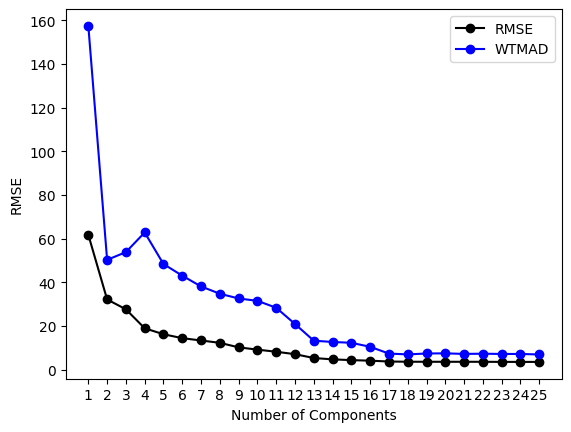

Best number of components for       R2:   25 [    1.00]
Best number of components for     RMSE:   25 [    3.61]
Best number of components for    WTMAD:   25 [    7.01]
Using  25  components


In [8]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

setname = "Full"
print("Running PLS for dataset: ", setname)

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].features, \
              models_results[setname].labels)
setlist = models_results[setname].setnames  
supersetlist = models_results[setname].supersetnames
maxcomp = X.shape[1]
ncomps, rmses, r2s, wtmads, loormses = \
          models.pls_model (X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp-8, split = False,\
          plot = True, loo=False)
r2max_comps = np.argmax(r2s)+1
rmsemin_comps = np.argmin(rmses)+1
wtmadmin_comps = np.argmin(wtmads)+1
#loormsemin_comps = np.argmin(loormses)+1
print("Best number of components for       R2: %4d [%8.2f]"%(\
      r2max_comps, r2s[r2max_comps-1]))
print("Best number of components for     RMSE: %4d [%8.2f]"%(\
      rmsemin_comps, rmses[rmsemin_comps-1]))
print("Best number of components for    WTMAD: %4d [%8.2f]"%(\
      wtmadmin_comps, wtmads[wtmadmin_comps-1]))
#print("Best number of components for LOO RMSE: %4d [%8.2f]"%(\
#      loormsemin_comps, loormses[loormsemin_comps-1]))
#compstouse = min(r2max_comps, rmsemin_comps, wtmadmin_comps, loormsemin_comps)
compstouse = min(r2max_comps, rmsemin_comps, wtmadmin_comps)
print("Using ", compstouse, " components")

In [9]:
# perform features importance analysis
setname = "Full"   
print("Running PLS for dataset: ", setname)
print("  Using ", compstouse, " components")
X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].features, \
              models_results[setname].labels)
setlist = []
for i, s in enumerate(models_results[setname].setnames):
    ss = models_results[setname].supersetnames[i]
    setlist.append(ss + "_" + s)

plsmodel = PLSRegression(n_components=compstouse)
plsmodel.fit(X, Y)
y_pred = plsmodel.predict(X) 
   
cv = LeaveOneOut()
model = PLSRegression(n_components=compstouse)
scores = cross_val_score(model, X, Y, \
            scoring='neg_mean_squared_error', \
            cv=cv, n_jobs=-1)
loormse = np.sqrt(np.mean(np.absolute(scores)))
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
if len(y_pred.shape) == 2:
    y_pred = y_pred[:,0]
wtmadf = commonutils.wtmad2(setlist, Y, y_pred)
wtmad = wtmadf["Full"]
print("      RMSE: %10.2f"%rmse)
print("        R2: %10.2f"%r2)
print("     WTMAD: %10.2f"%wtmad)
print("  LOO RMSE: %10.2f"%loormse)

Running PLS for dataset:  Full
  Using  25  components
      RMSE:       3.61
        R2:       1.00
     WTMAD:       7.01
  LOO RMSE:       3.90


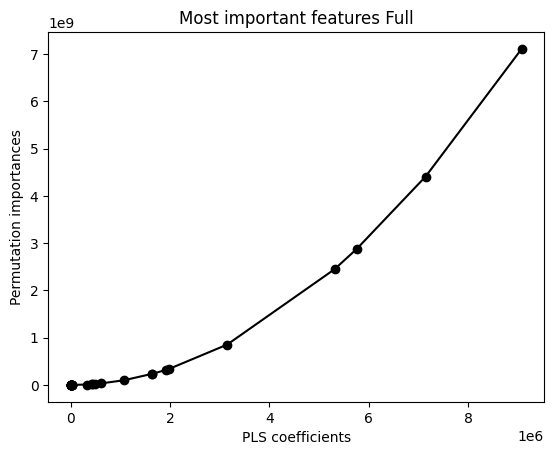

Most important features
                         PBE-TZVP_Potential_Energy_difftoref 9073667.15 7106628677.50
                           PBE-TZVP_Kinetic_Energy_difftoref 7141862.31 4407668898.27
                      PBE-TZVP_One_Electron_Energy_difftoref 5756119.32 2876730899.57
                      PBE-TZVP_Two_Electron_Energy_difftoref 5309655.37 2446809016.07
                PBE-TZVP_FINAL_SINGLE_POINT_ENERGY_difftoref 3147163.58 851898892.90
                       PBE-SVP_Two_Electron_Energy_difftoref 1974175.70 336218344.44
                       PBE-SVP_One_Electron_Energy_difftoref 1911995.80 315128557.96
                            PBE-SVP_Kinetic_Energy_difftoref 1644133.10 236207874.93
                          PBE-SVP_Potential_Energy_difftoref 1626863.93 231539817.62
                                  PBE0-TZVP_Potential_Energy 1069882.21 98441032.77
                         PBE0-TZVP_FINAL_SINGLE_POINT_ENERGY  608096.84 31780483.70
                                    PBE

In [10]:
most_importante_features = []
result = permutation_importance(plsmodel, X, Y, n_repeats=10, \
                                random_state=42, n_jobs=2)
pfi_sorted_idx = result.importances_mean.argsort()
#compute absolute values of the PLS coefficients
coef = np.abs(plsmodel.coef_).flatten()
#sort the coefficients
sorted_idx = np.argsort(coef)

# scatter plot of the most important features
plt.clf()
plt.rcParams['figure.figsize'] = 15,15
fis = [np.mean(result.importances[i].T) for i in pfi_sorted_idx]
cfs = [coef[i] for i in sorted_idx]
plt.plot(cfs, fis, '-o', color='black')
plt.xlabel("PLS coefficients")
plt.ylabel("Permutation importances")
plt.title("Most important features " + setname)
plt.show()

# print the most important features
print("Most important features")
for i in reversed(pfi_sorted_idx):
    most_importante_features.append(features_names[i])
    print("%60s"%features_names[i], \
          "%10.2f"%coef[i], \
          "%10.2f"%np.mean(result.importances[i].T))

In [11]:
# remove corralted features 
CORRCUT = 0.95

setname = "Full"
touse = set()
# add by default the selected FINAL_SINGLE_POINT_ENERGY
#touse.add(selected_functional + "-" + \
#            selected_basisset + "_" + \
#            "FINAL_SINGLE_POINT_ENERGY")
toremove = set()
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for feat1 in most_importante_features:
    print("Checking feature ", feat1)
    if feat1 not in toremove:
        touse.add(feat1)
        print("  Adding feature ", feat1)
        for idx, v in enumerate(corr[feat1]):
            if v > CORRCUT:
                feat2 = corr.columns[idx]
                if feat2 != feat1:
                    print("    Correlated with ", feat2, " ", v)
                    toremove.add(feat2)
                    print("      Removing feature ", feat2)

z = touse.intersection(toremove) 
if len(z) != 0:
    print("Error in removing correlated features")
    print("z = ", z)
    sys.exit(1)
    
print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

Checking feature  PBE-TZVP_Potential_Energy_difftoref
  Adding feature  PBE-TZVP_Potential_Energy_difftoref
    Correlated with  PBE-TZVP_Kinetic_Energy_difftoref   0.9931744641066756
      Removing feature  PBE-TZVP_Kinetic_Energy_difftoref
Checking feature  PBE-TZVP_Kinetic_Energy_difftoref
Checking feature  PBE-TZVP_One_Electron_Energy_difftoref
  Adding feature  PBE-TZVP_One_Electron_Energy_difftoref
    Correlated with  PBE-TZVP_Two_Electron_Energy_difftoref   0.9872824488625814
      Removing feature  PBE-TZVP_Two_Electron_Energy_difftoref
Checking feature  PBE-TZVP_Two_Electron_Energy_difftoref
Checking feature  PBE-TZVP_FINAL_SINGLE_POINT_ENERGY_difftoref
  Adding feature  PBE-TZVP_FINAL_SINGLE_POINT_ENERGY_difftoref
Checking feature  PBE-SVP_Two_Electron_Energy_difftoref
  Adding feature  PBE-SVP_Two_Electron_Energy_difftoref
    Correlated with  PBE-SVP_One_Electron_Energy_difftoref   0.9959260874362819
      Removing feature  PBE-SVP_One_Electron_Energy_difftoref
Checking fe

SystemExit: 1

In [ ]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [ ]:
#compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


df = pd.DataFrame(models_results["Full"].uncorrelated_features)
vif = pd.DataFrame()
#scale data before computing VIF
df = df.apply(lambda x: (x - np.mean(x)) / np.std(x))
vif["features"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# histogram of VIF
plt.clf()
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=1)
sns.histplot(vif["VIF"])
plt.show()
# mean and stdev of VIF
print("VIF mean and stdev")
print(vif["VIF"].mean(), vif["VIF"].std())

print("VIF")
for v in vif.values:
    if v[1] > 160:
        print(v[0], v[1])
        for setname in fullsetnames:
            if v[0] in models_results[setname].uncorrelated_features:
                del models_results[setname].uncorrelated_features[v[0]]

In [ ]:
setname = "Full"
print("Uncorrelated features ", len(models_results[setname].uncorrelated_features))
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)

In [ ]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

comptuseperset = {}
for setname in list(supersetnames)+["Full"]:
    comptuseperset[setname] = 0

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running PLS for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = models_results[setname].setnames
   supersetlist = models_results[setname].supersetnames
   maxcomp = X.shape[1]
   ncomps, rmses, r2s, wtmads, loormses = \
          models.pls_model (X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp, split = False,\
          plot = True)
   r2max_comps = np.argmax(r2s)+1
   rmsemin_comps = np.argmin(rmses)+1
   wtmadmin_comps = np.argmin(wtmads)+1
   loormsemin_comps = np.argmin(loormses)+1
   print("Best number of components for       R2: %4d [%8.2f]"%(\
      r2max_comps, r2s[r2max_comps-1]))
   print("Best number of components for     RMSE: %4d [%8.2f]"%(\
      rmsemin_comps, rmses[rmsemin_comps-1]))
   print("Best number of components for    WTMAD: %4d [%8.2f]"%(\
      wtmadmin_comps, wtmads[wtmadmin_comps-1]))
   print("Best number of components for LOO RMSE: %4d [%8.2f]"%(\
      loormsemin_comps, loormses[loormsemin_comps-1]))

   compstouse = wtmadmin_comps
   comptuseperset[setname] = compstouse 

In [ ]:
# select components to use
#comptuseperset["BARRIER_HEIGHTS"] = 14
#comptuseperset["INTRAMOLECULAR_INTERACTIONS"] = 15
#comptuseperset["SMALL_MOLECULES"] = 15
#comptuseperset["INTERMOLECULAR_INTERACTIONS"] = 16
#comptuseperset["LARGE_SYSTEMS"] = 16
#comptuseperset["Full"] = 15
for setname in list(supersetnames)+["Full"]:   
   print("Running PLS for dataset: ", setname)
   print("  Using ", comptuseperset[setname], " components")
   compstouse = comptuseperset[setname]
   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = models_results[setname].setnames
   models_results[setname].plsmodel = PLSRegression(n_components=compstouse)
   models_results[setname].plsmodel.fit(X, Y)
   models_results[setname].y_pred = \
      models_results[setname].plsmodel.predict(X) 
   
   cv = LeaveOneOut()
   model = PLSRegression(n_components=compstouse)
   scores = cross_val_score(model, X, Y, \
            scoring='neg_mean_squared_error', \
            cv=cv, n_jobs=-1)
   loormse = np.sqrt(np.mean(np.absolute(scores)))
   rmse = mean_squared_error(Y, models_results[setname].y_pred, squared=False)
   r2 = r2_score(Y, models_results[setname].y_pred)
   y_pred = models_results[setname].y_pred
   if len(y_pred.shape) == 2:
            y_pred = y_pred[:,0]
   wtmadf = commonutils.wtmad2(setlist, Y, y_pred)
   wtmad = wtmadf[setname]
   print("      RMSE: %10.2f"%rmse)
   print("        R2: %10.2f"%r2)
   print("     WTMAD: %10.2f"%wtmad)
   print("  LOO RMSE: %10.2f"%loormse)

In [ ]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].uncorrelated_features, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


In [ ]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel
printonlysuperset = True
setnametouse = deepcopy(fullsetnames)
setnametouse.remove("Full")

ypredFull = []
setnamesFull = []

for setname in setnametouse:
    if setname in supersetnames:
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    setlist = models_results[setname].setnames
    y_pred_full = pls_model_full.predict(X)
    if len(y_pred_full.shape) == 2:
        y_pred_full = y_pred_full[:,0]
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    y_pred = pls_model_ssetname.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred[:,0]
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    if setname in supersetnames:
        ypredFull.extend(list(y_pred))
        setnamesFull.extend(setlist)
        print("Results for ", setname, " dim: ", len(Y))
        wtmad2df = commonutils.wtmad2(setlist, Y, y_pred)
        wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
        wtmad2 = wtmad2df[setname]
        wtmad2_full = wtmad2_fulldf[setname]
        print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
        print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtmad) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtmad)
        
    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE       (PLS ssetname) %7.3f"%rmse)
    print("RMSE           (PLS Full) %7.3f"%rmse_full,)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    fig, ax = plt.subplots()
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label='Best our method')
    ax.scatter(Y, y_pred_full, c='r', s=50, label='PLS full model')
    ax.scatter(Y, y_pred, c='b', s=50, label='PLS ssetname model')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()

print("Results for Full sim ", len(ypredFull))
X, Y, features_names = \
        commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
setlist = models_results["Full"].setnames
wtmad2df = commonutils.wtmad2(setnamesFull, Y, ypredFull)
wtmad2 = wtmad2df["Full"]
rmse = mean_squared_error(Y, ypredFull, squared=False)

y_pred_full = pls_model_full.predict(X)
if len(y_pred_full.shape) == 2:
    y_pred_full = y_pred_full[:,0]
rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
wtmad2_full = wtmad2_fulldf["Full"]

print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
print("WTAMD2 (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_wtmad)
print("WTAMD2    (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_wtmad)
rmse = mean_squared_error(models_results["Full"].labels, ypredFull, squared=False)
print("RMSE       (PLS ssetname) %7.3f"%rmse)
print("RMSE           (PLS Full) %7.3f"%rmse_full)
print("RMSE   (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_rmse)
print("RMSE      (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_rmse)

plt.clf()
plt.rcParams['figure.figsize'] = 10,10
fig, ax = plt.subplots()
ax.scatter(Y, y_pred_full, c='r', s=50, label='PLS full model')
ax.scatter(Y, ypredFull, c='b', s=50, label='PLS ssetname model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend(loc="upper left")
plt.title("Full")
plt.show()


In [ ]:
#test and dump PLS equations
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    print("Equations for dataset: ", setname)
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)
    X_e = X.copy()
    X_e -= pls_model_full._x_mean
    X_e /= pls_model_full._x_std
    y_pred_full_e = np.dot(X_e, pls_model_full.coef_.T)
    y_pred_full_e += pls_model_full._y_mean
    rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
    print("   Full dataset equations Y mean %7.3f"%pls_model_full._y_mean)
    for i, f in enumerate(features_names):
        print(" %50s %10.3f [%15.3f %15.3f]"%(f, \
            pls_model_full.coef_.T[i],
            pls_model_full._x_mean[i], 
            pls_model_full._x_std[i]))

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    X_e = X.copy()
    X_e -= pls_model_ssetname._x_mean
    X_e /= pls_model_ssetname._x_std
    y_pred_e = np.dot(X_e, pls_model_ssetname.coef_.T)
    y_pred_e += pls_model_ssetname._y_mean
    rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
    for i, f in enumerate(features_names):
        print(" %50s %10.3f [%15.3f %15.3f]"%(f, \
            pls_model_ssetname.coef_.T[i],
            pls_model_ssetname._x_mean[i], 
            pls_model_ssetname._x_std[i]))

    print()
    print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
    print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    print()


In [ ]:
# perform features importance analysis
for setname in list(supersetnames)+["Full"]:   

    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    model = models_results[setname].plsmodel
    result = permutation_importance(model, X, Y, n_repeats=10, \
                                random_state=42, n_jobs=2)
    pfi_sorted_idx = result.importances_mean.argsort()
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[pfi_sorted_idx].T, vert=False, \
               labels=np.array(features_names)[pfi_sorted_idx])
    ax.set_title("Permutation Importances " + setname)
    fig.tight_layout()
    plt.show()
    
    #compute absolute values of the PLS coefficients
    coef = np.abs(model.coef_).flatten()
    #sort the coefficients
    sorted_idx = np.argsort(coef)
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fig, ax = plt.subplots()
    ax.barh(np.array(features_names)[sorted_idx], \
            coef[sorted_idx])
    ax.set_title("PLS coefficients " + setname)
    fig.tight_layout()
    plt.show()

    # scatter plot of the most important features
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fis = [np.mean(result.importances[i].T) for i in pfi_sorted_idx]
    cfs = [coef[i] for i in sorted_idx]
    plt.plot(cfs, fis, '-o', color='black')
    plt.xlabel("PLS coefficients")
    plt.ylabel("Permutation importances")
    plt.title("Most important features " + setname)
    plt.show()
